In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [32]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [33]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [34]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [35]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [36]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier

primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [37]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

ugrhi10 = trainingd

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [38]:
ugrhi10

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [39]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '06 - ALTO TIÊTE']

In [40]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [41]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [42]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())

valor NaN: 2


In [43]:
trainingd = trainingd.dropna(axis=0,how='any')


In [44]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())
trainingd

valor NaN: 0


,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [45]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < inferior.valor)]

outlier

primeiro_quartil: valor    6.583333
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.002667
Name: 0.75, dtype: float64
fig: valor    0.419333
dtype: float64
Inferior: valor    5.954333
dtype: float64
Superior: valor    7.631667
dtype: float64


C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1979-11-30,5.916667
1985-03-31,5.883333


In [46]:
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [47]:
#Remove a última linha do dataframe
trainingd = trainingd.drop(trainingd[trainingd.index == '2019-09-30'].index)

In [48]:
trainingd.describe()

,valor
count,248.000000
mean,6.793328
std,0.294764
min,5.883333
25%,6.581944
50%,6.838095
75%,7.001821
max,7.405000


In [49]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingds.valor < inferior.valor] = 6.79

ugrhi06 = trainingd

outlier = trainingd[(trainingd.valor < inferior.valor)]

outlier

,valor
data_coleta,


In [140]:
X = ugrhi10
y = ugrhi06

assert X.shape == (len(X),1)
assert y.shape == (len(y),1)

In [141]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

In [142]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

#y_train

In [143]:
len(X_train)

173

In [144]:
regression = RandomForestRegressor()
regression.fit(X_train,y_train)


y_pred = regression.predict(X_test)

y_pred = sc.inverse_transform(y_pred.reshape(1, -1))

X_test = sc.inverse_transform(X_test)
y_test = sc.inverse_transform(y_test)

C:\Users\Anderson\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [145]:
y_predt = regression.predict(X_train)

y_predt = sc.inverse_transform(y_predt.reshape(1, -1))

X_train = sc.inverse_transform(X_train)


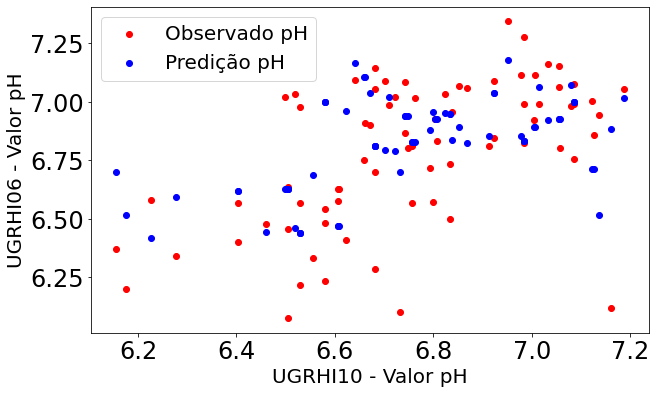

In [146]:
'''
print(y_pred.reshape(-1, 1))
print("-----")
print(X_test)
'''
plt.scatter(X_test,y_test,color='red', label='Observado pH')
#plt.scatter(X_train,y_train,color='yellow', label='Dados treino')
plt.scatter(X_test,y_pred.reshape(-1, 1),color='blue',label='Predição pH')
plt.xlabel('UGRHI10 - Valor pH')
plt.ylabel('UGRHI06 - Valor pH')
plt.legend()
#plt.title('Predição RL')
plt.show()



In [147]:
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

In [148]:
print('\n')
print('MAPE TESTE:',round(mape(y_pred.reshape(-1,1),y_test)[0],2),'%')
print('RMSE TESTE:',round(rmse(y_pred.reshape(-1,1),y_test),2))
print('R TESTE:',round(r2(y_pred.reshape(-1,1),y_test),2))
print('\n')

print('\n')
print('MAPE TREINO:',round(mape(y_predt.reshape(-1,1),X_train)[0],2),'%')
print('RMSE TREINO:',round(rmse(y_predt.reshape(-1,1),X_train),2))
print('R TREINO:',round(r2(y_predt.reshape(-1,1),X_train),2))
print('\n')



MAPE TESTE: 2.61 %
RMSE TESTE: 0.29
R TESTE: 0.09




MAPE TREINO: 4.23 %
RMSE TREINO: 0.21
R TREINO: 0.44




MAPE TESTE: 1.98 %
RMSE TESTE: 0.25
R TESTE: 0.19




MAPE TREINO: 3.74 %
RMSE TREINO: 0.19
R TREINO: 0.5

In [89]:
novo = trainingd.reset_index()

In [102]:
X = novo['data_coleta'].values
y = novo['valor'].values

previsoes =y_pred

#len(X[174:248])

p = []

for i in range(len(previsoes)):
    p.append(round(previsoes[i][0],2))

    

obj = {'data': X[173:248], 'prev': p}

dfnovo = pd.DataFrame(data=obj)
dfnovo

,data,prev
0,2007-03-31,6.93
1,2007-05-31,6.81
2,2007-07-31,6.83
3,2007-09-30,6.75
4,2007-11-30,6.79
...,...,...
70,2018-11-30,6.71
71,2019-01-31,6.63
72,2019-03-31,6.74
73,2019-05-31,6.81


In [103]:
dfnovo.loc[dfnovo.data > '2016-11-01']

,data,prev
58,2016-11-30,6.60
59,2017-01-31,6.81
60,2017-03-31,6.79
61,2017-05-31,6.58
62,2017-07-31,6.49
63,2017-09-30,6.98
64,2017-11-30,7.05
65,2018-01-31,6.89
66,2018-03-31,6.51
67,2018-05-31,6.83
